# Data Intersection

In this first part we'll explore the dataset and extract a white list of only the "case ID" present in all data.
The variable "SAVE_FILE" specify if we want to save the white list in a file.

In [51]:
WL_SAVE_FILE = True
WL_OUTPUT_FOLDER = "."

LIST_FILE_PATH_JSON = [
    "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/JSON/CopyNumber.json",
    "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/JSON/GeneExpression.json",
    "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/JSON/Methylation.json",
    "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/JSON/OverallSurvival.json"
]

In [52]:
import json

In [53]:
list_list_case_id = []

# Iterate over each file.
for file_name in LIST_FILE_PATH_JSON:
    list_case_id = []
    with open(file_name, 'r') as file:
        file_parsed = json.load(file)
        # Iterate over each case.
        for case in file_parsed:
            case_id = case["cases"][0]["case_id"]
            if not case_id in list_case_id:
                list_case_id.append(case_id)
    print(f"{file_name}: {len(list_case_id)}")
    list_list_case_id.append(list_case_id)


# Find intersection of all the case id.
intersection_of_case_id = set.intersection(*map(set,list_list_case_id))

if WL_SAVE_FILE:
    with open(WL_OUTPUT_FOLDER + "/" + 'case_id_white_list.json', 'w', encoding='utf-8') as f:
        json.dump(list(intersection_of_case_id), f, ensure_ascii=False, indent=4)

print(f"Total intersection: {len(intersection_of_case_id)}")



/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/JSON/CopyNumber.json: 567
/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/JSON/GeneExpression.json: 416
/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/JSON/Methylation.json: 569
/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/JSON/OverallSurvival.json: 580
Total intersection: 407


# Data Analisys and subset division

In this second part we'll identify, based on the previous white list, which case have an attribute "days_to_death" or "days_to_last_followup", which define if the user died or was seen alive until the last followup.
Then after an analisys of the two subset we'll try to balance them.

In [54]:
A_SAVE_FILE = True
A_OUTPUT_FOLDER = "."

OS_FOLDER_PATH = "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/OverallSurvival"
PATH_OS_JSON = "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/JSON/OverallSurvival.json"

In [55]:
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import re
import xml.etree.ElementTree as ET
import seaborn as sns
import numpy as np

### Get file name corresponding to white list "case ID"

In [56]:
list_file_name_white_list = []

save_file_to_id_relation = {}

with open(PATH_OS_JSON, 'r') as file:
    file_parsed = json.load(file)
    for case in file_parsed:
        case_id = case["cases"][0]["case_id"]
        if case_id in intersection_of_case_id:
            save_file_to_id_relation[case['file_name']] = case_id
            list_file_name_white_list.append(case['file_name'])

### Read file in white list

In [57]:
dirs = [x for x in Path(OS_FOLDER_PATH).iterdir() if x.is_dir()]

case_id_to_day_relation = {}

dead_list = []
alive_list = []

r = re.compile('.*.xml')

for dir in dirs:
    file_name_list = [x for x in dir.iterdir() if r.match(str(x))]

    if len(file_name_list) == 1:
        file_name = file_name_list[0]
        relative_file_name = str(file_name).split("/")[-1]
        if relative_file_name in list_file_name_white_list:
            # We found a file present in the white list.
            tree = ET.parse(file_name)
            root = tree.getroot()
            namespaces = {
                'admin': 'http://tcga.nci/bcr/xml/administration/2.7',
                'ov': 'http://tcga.nci/bcr/xml/clinical/ov/2.7',
                'clin_shared': "http://tcga.nci/bcr/xml/clinical/shared/2.7"
            }
            Days_to_death = root.findall('.//clin_shared:days_to_death',namespaces)[0].text
            Days_to_last_followup = root.findall('.//clin_shared:days_to_last_followup',namespaces)[0].text

            case_id = save_file_to_id_relation[relative_file_name]
            if not Days_to_death == None:                   # Dead.
                dead_list.append(Days_to_death)
                case_id_to_day_relation[case_id] = {'type': "dead", 'value': Days_to_death}
            elif not Days_to_last_followup == None:         # Alive.
                alive_list.append(Days_to_last_followup)
                case_id_to_day_relation[case_id] = {'type': "alive", 'value': Days_to_last_followup}
    else:
        raise Exception("Multiple \'xml\' file in the same folder.")

### Save value of Days_to_death or Days_to_last_followup

In [ ]:
if A_SAVE_FILE:
    with open(A_OUTPUT_FOLDER + "/" + 'case_id_to_value_relation.json', 'w', encoding='utf-8') as f:
        json.dump(case_id_to_day_relation, f, ensure_ascii=False, indent=4)

In [58]:
dead = pd.Series([int(d) for d in dead_list])
alive = pd.Series([int(d) for d in alive_list])

### Graph the subset

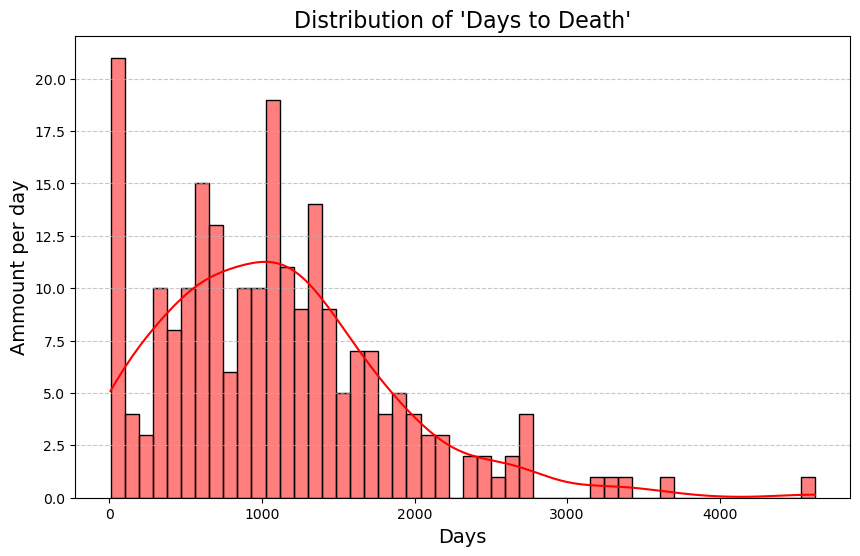

In [59]:
plt.figure(figsize=(10, 6))
sns.histplot(dead, bins=50, kde=True, color="red")
plt.title("Distribution of \'Days to Death\'", fontsize=16)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Ammount per day", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

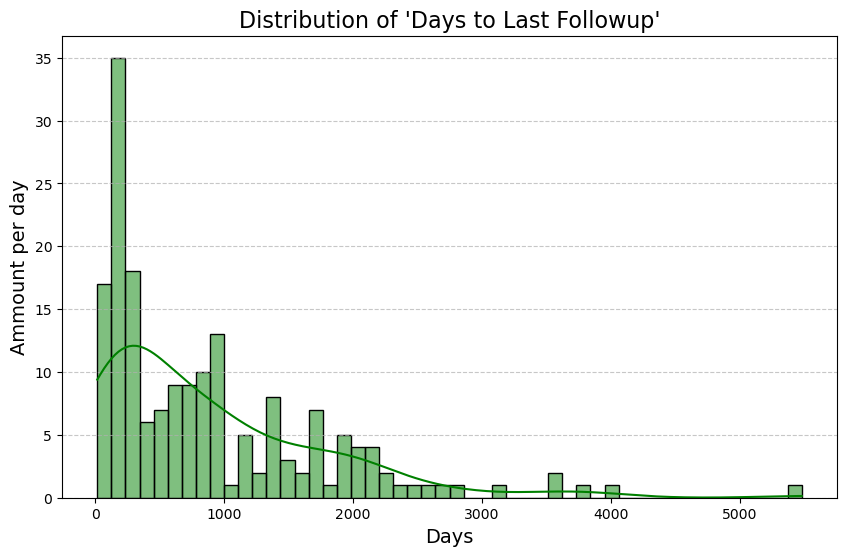

In [60]:
plt.figure(figsize=(10, 6))
sns.histplot(alive, bins=50, kde=True, color="green")
plt.title("Distribution of \'Days to Last Followup\'", fontsize=16)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Ammount per day", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Find a suitable division

How we divide them?
Well first we want to remove the case where the case ID have a "days to last followup" is too small, the reason is that we are not sure if they are still alive or not, and we would like to conisder people with "days to death" which are similar to help the model learn better how to classify them.
So we want a range for the "days to death" centered on the median of the list, and we would like to keep all the "days to last followup" which excede the upper bound of this range, the idea is that since most people die in a specific range, then we would like to consider alive only the people that have a checkup at least after this range, then we conider them reasonably alive.
But to keep two subset balanced and as big as possible we'll graph the ammount of people in each subset while increasing the dimension of the range taken in the "days to death".

In [61]:
mean_value = np.mean(dead)
median_value = np.median(dead)
std_deviation = np.std(dead)

center_curve = int(median_value)
 
print(f"Mean: {mean_value:.2f}")
print(f"Median: {median_value}")
print(f"Standard Deviation: {std_deviation:.2f}")

Mean: 1092.93
Median: 1032.5
Standard Deviation: 753.95


Range value: 180	Ammount for each subset: 49
Range value: 181	Ammount for each subset: 49


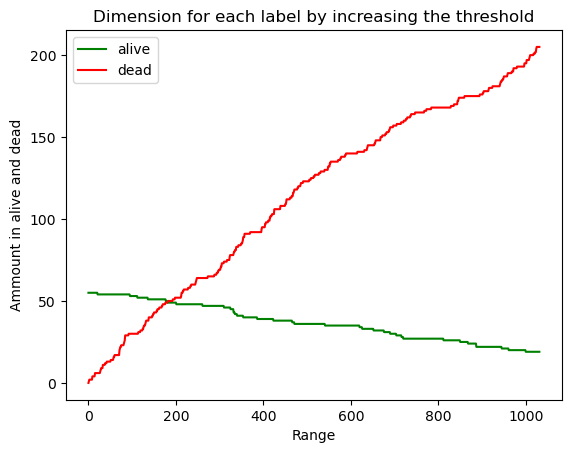

In [62]:
incremental_death = []

for i in range (center_curve):
    current_val = len([val for val in dead if (val < center_curve + i) and (val > center_curve - i)])
    incremental_death.append(current_val)


incremental_alive = []

for i in range (center_curve):
    current_val = len([val for val in alive if (val > center_curve + i)])
    incremental_alive.append(current_val)


# Find intersection
for i in range(center_curve):
    if incremental_alive[i] == incremental_death[i]:
        print(f"Range value: {i}\tAmmount for each subset: {incremental_death[i]}")


# Using Numpy to create an array X
X = pd.Series(range(center_curve))

# Assign variables to the y axis part of the curve
y = incremental_alive
z = incremental_death

# Plotting both the curves simultaneously
plt.plot(X, y, color='g', label='alive')
plt.plot(X, z, color='r', label='dead')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Range")
plt.ylabel("Ammount in alive and dead")
plt.title("Dimension for each label by increasing the threshold")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

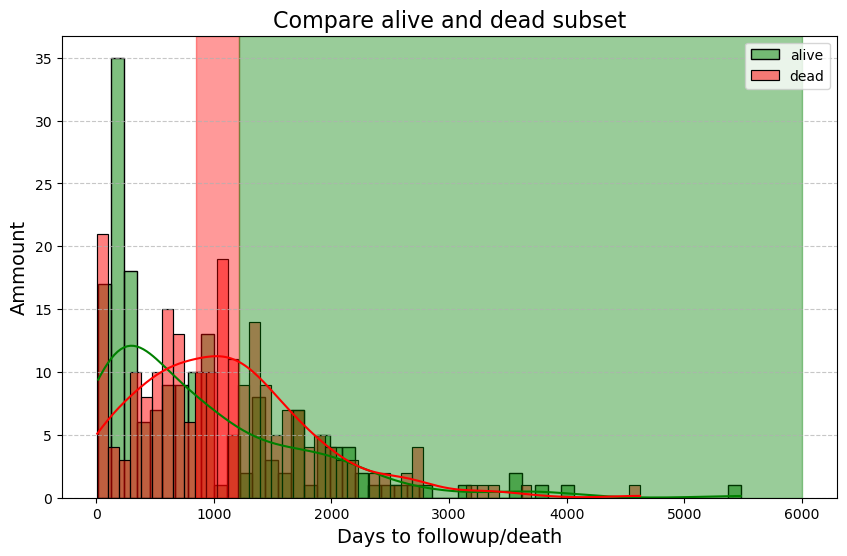

In [63]:
plt.figure(figsize=(10, 6))
sns.histplot(alive, bins=50, kde=True, color="green", label="alive")
sns.histplot(dead, bins=50, kde=True, color="red", label="dead")
plt.title("Compare alive and dead subset", fontsize=16)
plt.xlabel("Days to followup/death", fontsize=14)
plt.ylabel("Ammount", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axvspan(1032 - 180, 1032 + 180, color='red', alpha=0.4)
plt.axvspan(1032 + 180, 6000, color='green', alpha=0.4)
plt.legend()
plt.show()

In [64]:
RangeAlive = 1032 + 180
RangeDead = [1032 - 180, 1032 + 180]

### Save file

In [65]:
if A_SAVE_FILE:
    dirs = [x for x in Path(OS_FOLDER_PATH).iterdir() if x.is_dir()]

    list_out_file_name_dead = []
    list_out_file_name_alive = []

    r = re.compile('.*.xml')

    for dir in dirs:
        file_name_list = [x for x in dir.iterdir() if r.match(str(x))]

        if len(file_name_list) == 1:
            file_name = file_name_list[0]
            relative_file_name = str(file_name).split("/")[-1]
            if relative_file_name in list_file_name_white_list:
                # We found a file present in the white list.
                tree = ET.parse(file_name)
                root = tree.getroot()
                namespaces = {
                    'admin': 'http://tcga.nci/bcr/xml/administration/2.7',
                    'ov': 'http://tcga.nci/bcr/xml/clinical/ov/2.7',
                    'clin_shared': "http://tcga.nci/bcr/xml/clinical/shared/2.7"
                }
                Days_to_death = root.findall('.//clin_shared:days_to_death',namespaces)[0].text
                Days_to_last_followup = root.findall('.//clin_shared:days_to_last_followup',namespaces)[0].text

                if not Days_to_death == None:                   # Dead.
                    if int(Days_to_death) >= RangeDead[0] and int(Days_to_death) <= RangeDead[1]:
                        list_out_file_name_dead.append(relative_file_name)
                elif not Days_to_last_followup == None:         # Alive.
                    if int(Days_to_last_followup) > RangeAlive:
                        list_out_file_name_alive.append(relative_file_name)
        else:
            raise Exception("Multiple \'xml\' file in the same folder.")

    # We have the file name, now we want the case_id.
    list_out_case_id_dead = set()
    list_out_case_id_alive = set()

    with open(PATH_OS_JSON, 'r') as file:
        file_parsed = json.load(file)
        for case in file_parsed:
            file_name = case['file_name']
            if file_name in list_out_file_name_dead:
                list_out_case_id_dead.add(case["cases"][0]["case_id"])
            elif file_name in list_out_file_name_alive:
                list_out_case_id_alive.add(case["cases"][0]["case_id"])
            
    with open(A_OUTPUT_FOLDER + "/" + 'case_id_white_list_dead.json', 'w', encoding='utf-8') as f:
        json.dump(list(list_out_case_id_dead), f, ensure_ascii=False, indent=4)
    with open(A_OUTPUT_FOLDER + "/" + 'case_id_white_list_alive.json', 'w', encoding='utf-8') as f:
        json.dump(list(list_out_case_id_alive), f, ensure_ascii=False, indent=4)
